<a href="https://colab.research.google.com/github/ailunguo/Test/blob/main/%E5%BE%AA%E7%8E%AF%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install d2l

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.6/112.6 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 70.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 89.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 110.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 81.5 MB/s eta 0:00:00
  Created wheel for pandas: filename=pandas-1.2.4-cp310-cp310-linux_x86_64.whl size=34330696 sha256=a46f0639fb1131d85b00245f0082b7a2dd1c72d8f

In [4]:
!pip install --upgrade matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.3/98.3 kB 12.3 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
arviz 0.15.1 requires pandas>=1.3.0, but you have pandas 1.2.4 which is incompatible.
d2l 0.17.6 requires matplotlib==3.5.1, but you have matplotlib 3.7.2 which is incompatible.
mizani 0.8.1 requires pandas>=1.3.5, but you have pandas 1.2.4 which is incompatible.
plotnine 0.10.1 requires pandas>=1.3.5, but you have pandas 1.2.4 w

In [5]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [6]:
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [7]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)

    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)

    # 附加梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [8]:
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),)

In [9]:
def rnn(inputs, state, params):
    # inputs的形状：（时间步数量， 批量大小， 词表大小
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # X的形状：（批量大小， 词表大小）
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

In [10]:
# d2l.RNNModelScratch
class RNNModelScratch:
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [11]:
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

In [12]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

In [13]:
d2l.try_gpu()

device(type='cuda', index=0)

In [14]:
d2l.predict_ch8('time traveller', 10, net, vocab, d2l.try_gpu())

'time traveller ibggggggg'

perplexity 1.0, 64020.4 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby
travelleryou can show black is white by argument said filby


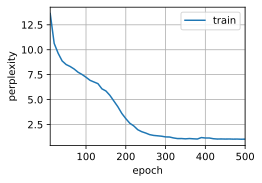

In [15]:
num_epochs, lr = 500, 1
d2l.train_ch8(net,train_iter, vocab, lr, num_epochs, d2l.try_gpu())

In [20]:
d2l.predict_ch8('time traveller ', 100, net, vocab, d2l.try_gpu())

'time traveller with a slight accession ofcheerfulness really this is what is meant by the fourth dimensionthough so'

In [22]:
len(vocab)

28

In [23]:
F.one_hot(torch.tensor([0, 2]), len(vocab)).shape

torch.Size([2, 28])

In [25]:
X = torch.arange(10).reshape((2, 5))
F.one_hot(X, 28).shape

torch.Size([2, 5, 28])

In [ ]:
# 输入数据的维度（时间步数，批量大小，词表大小）
# 输入单个样本大小 = 输出样本大小 = 词表大小
# rnn得到每个时间步上的结果和最后的隐藏状态
# （5，2，28）（2，28）（2，512）